In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, recall_score, \
    accuracy_score, precision_score, f1_score, plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)

Importing the prepared data with features that have been deliberately selected

In [2]:
df = pd.read_csv("./data/logistic_model_features.csv")

In [3]:
df.head(2)

,Unnamed: 0,id,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,0,69572,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,1,8776,NaN,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional


Preparing the target category for appropriate modeling

In [4]:
ohe = OneHotEncoder(sparse=False)

In [5]:
target = pd.DataFrame(ohe.fit_transform(df[['status_group']]), index=df.index, columns=['Functional', "Needs_Repair", "Non-Functional"])

Verifying that the correct values have been properly one hot encoded

In [6]:
target.value_counts()

Functional  Needs_Repair  Non-Functional
1.0         0.0           0.0               32259
0.0         0.0           1.0               22824
            1.0           0.0                4317
dtype: int64

In [7]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### Also need to convert permit column to different type, bool not compatible

In [8]:
df['permit'] = df['permit'].astype(str)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         59400 non-null  int64  
 1   id                 59400 non-null  int64  
 2   amount_tsh         17761 non-null  float64
 3   gps_height         59400 non-null  int64  
 4   longitude          57588 non-null  float64
 5   latitude           59400 non-null  float64
 6   population         38019 non-null  float64
 7   construction_year  38691 non-null  float64
 8   funder             55765 non-null  object 
 9   installer          55745 non-null  object 
 10  basin              59400 non-null  object 
 11  region             59400 non-null  object 
 12  region_code        59400 non-null  int64  
 13  district_code      59400 non-null  int64  
 14  lga                59400 non-null  object 
 15  ward               59400 non-null  object 
 16  scheme_management  555

### Preparing a train/test split with the correct data:

In [11]:
df.head(2)

,Unnamed: 0,id,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,0,69572,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,1,8776,NaN,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional


In [12]:
X = df.drop(['id', 'Unnamed: 0', 'status_group'], axis=1)
X.head(2)
y = target

In [13]:
y.head()

,Functional,Needs_Repair,Non-Functional
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [14]:
# Flatten the target variable
y_flat = np.argmax(np.array(y), axis=1)

y_flat
dbl_check = pd.Series(y_flat, name='Target')
check_df = pd.concat([X, dbl_check], axis=1)
check_df["Target"].value_counts()

y = check_df['Target']

In [18]:
# y, X.head()

# The data has been split into train and test groups in the standard ratio

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [20]:
X_train.shape, y_train.shape

((44550, 25), (44550,))

### Baseline model creation

I'll begin by setting up pre-processing pipelines for all of the data. 

In [43]:
subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler())
])

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='constant', fill_value="Missing", add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
], verbose=False)

In [22]:
CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [23]:
y_train.shape

(44550,)

In [24]:
baseline = Pipeline(steps=[
    ('CT', CT),
    ('baseline', LogisticRegression(n_jobs=-1, multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

In [25]:
%%time

baseline.fit(X_train, y_train)

CPU times: user 593 ms, sys: 358 ms, total: 951 ms
Wall time: 7min 41s


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd203735e50>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
               

In [33]:
baseline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd203735e50>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 

In [34]:
print("First run with the baseline model on TEST DATA:", baseline.score(X_test, y_test))

First run with the baseline model on TEST DATA: 0.7660606060606061


The first runthrough using only the baseline model with no specific hyper-parameter permutations resulted in the train and test data performing almost identically. Both scored 

# Analysis/Confusion Matrices of train/test splits

### Train data using the baseline model!

In [35]:
print("First run with the baseline model on TRAIN DATA:", baseline.score(X_train, y_train))

First run with the baseline model on TRAIN DATA: 0.7699438832772166


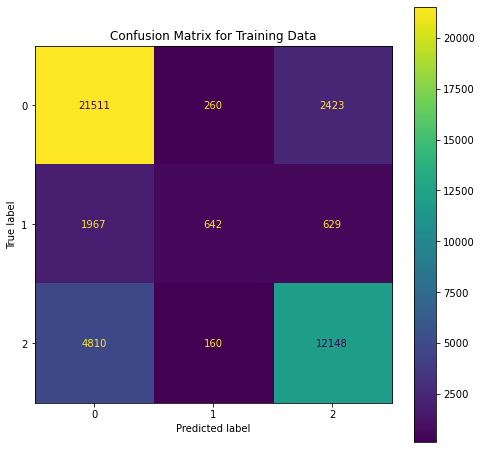

In [36]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(baseline, X_train, y_train, ax=ax)
ax.set_title("Confusion Matrix for Training Data")
plt.show();

In [96]:
# this code takes several minutes to run

# cross_val_score(baseline, X_train, y_train, scoring='neg_log_loss')

array([-0.58393141, -0.5819531 , -0.57212008, -0.57232312, -0.5743898 ])

In [37]:
mean_training_logloss = -np.mean([-0.58393141, -0.5819531 , -0.57212008, -0.57232312, -0.5743898 ])
print("Baseline Log Loss:", mean_training_logloss)

Baseline Log Loss: 0.576943502


### Test data using the baseline model

In [38]:
print("First run with the baseline model on TEST DATA:", baseline.score(X_test, y_test))

First run with the baseline model on TEST DATA: 0.7660606060606061


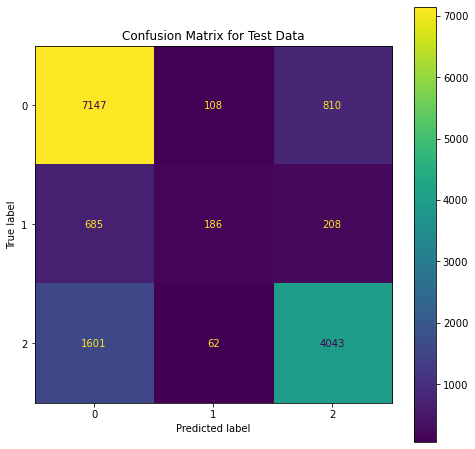

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(baseline, X_test, y_test, ax=ax)
ax.set_title("Confusion Matrix for Test Data")
plt.show();

# First Grid Search for parameter optimization

In [40]:
for i in baseline.get_params().keys():
    print(i)

memory
steps
verbose
CT
baseline
CT__n_jobs
CT__remainder
CT__sparse_threshold
CT__transformer_weights
CT__transformers
CT__verbose
CT__subpipe_numerics
CT__subpipe_cat
CT__subpipe_numerics__memory
CT__subpipe_numerics__steps
CT__subpipe_numerics__verbose
CT__subpipe_numerics__mean_impute
CT__subpipe_numerics__ss
CT__subpipe_numerics__mean_impute__add_indicator
CT__subpipe_numerics__mean_impute__copy
CT__subpipe_numerics__mean_impute__fill_value
CT__subpipe_numerics__mean_impute__missing_values
CT__subpipe_numerics__mean_impute__strategy
CT__subpipe_numerics__mean_impute__verbose
CT__subpipe_numerics__ss__copy
CT__subpipe_numerics__ss__with_mean
CT__subpipe_numerics__ss__with_std
CT__subpipe_cat__memory
CT__subpipe_cat__steps
CT__subpipe_cat__verbose
CT__subpipe_cat__cat_impute
CT__subpipe_cat__ohe
CT__subpipe_cat__cat_impute__add_indicator
CT__subpipe_cat__cat_impute__copy
CT__subpipe_cat__cat_impute__fill_value
CT__subpipe_cat__cat_impute__missing_values
CT__subpipe_cat__cat_impute__

In [117]:
params = {
    'CT__subpipe_numerics__mean_impute__strategy' : ['mean','median'],
    'baseline__solver' : ['sag', 'newton-cg'],  # 'newton-cholesky' not supported in logistic regression
    'baseline__max_iter': [200, 400],
    'baseline__C' : [0.001, 0.01],
    'baseline__tol' : [0.0001, 0.01]
}

In [42]:
X_train.shape

(44550, 25)

In [41]:
2*2*2*2*2*5

160

In [118]:
gs = GridSearchCV(
    estimator= baseline,     # First Simple Model Pipe
    param_grid=params,
    cv=5,
    verbose=1)

In [105]:
%%time

gs.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/env

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Use

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 

KeyboardInterrupt: 

In [106]:
print("hi")

hi


In [107]:
%timeit

### Since the gridsearch proved too computationally intensive, I will attempt to do it on a smaller sample of the data

In [49]:
target = pd.DataFrame(ohe.fit_transform(df[['status_group']]), index=df.index, columns=['Functional', "Needs_Repair", "Non-Functional"])

In [50]:
X = df.drop(['id', 'Unnamed: 0', 'status_group'], axis=1)
X.head(2)
y = target

In [51]:
# Flatten the target variable
y_flat = np.argmax(np.array(y), axis=1)

y_flat
dbl_check = pd.Series(y_flat, name='Target')
check_df = pd.concat([X, dbl_check], axis=1)
check_df["Target"].value_counts()

y = check_df['Target']

In [53]:
type(y)

pandas.core.series.Series

## New dataframe object created, needs to be sampled from in order to have a manageable size of data to work with. 

In [57]:
sample_df = pd.concat([X, y], axis=1)
sample_df.shape

(59400, 26)

### This df object has 10k samples, will then do train/test split, and set up model pipelines.

In [58]:
subset_df = sample_df.sample(10000, random_state=42)

In [61]:
subset_df.head(2)

,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,Target
2980,NaN,0,31.985658,-3.596360,NaN,NaN,Rural Water Supply And Sanitat,DWE,other,Shinyanga,17,5,other,other,WUG,NaN,True,other,wug,other,soft,dry,shallow well,groundwater,other,2
5246,NaN,0,32.832815,-4.944937,NaN,NaN,other,other,other,Tabora,14,6,Tabora Urban,other,VWC,NaN,True,india mark ii,vwc,never pay,milky,insufficient,shallow well,groundwater,hand pump,0


In [62]:
# set up X's, y's and split the data

X = subset_df.drop("Target", axis=1)
y = subset_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify= y)

In [63]:
X_train.shape, X_test.shape

((7500, 25), (2500, 25))

In [64]:
subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler())
])

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='constant', fill_value="Missing", add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  # sparse=False in failed version
], verbose=True)  # verbose = False on failed version

In [65]:
CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [66]:
y_train.shape

(7500,)

In [73]:
subset_model = Pipeline(steps=[
    ('CT', CT),
    ('subset', LogisticRegression(n_jobs=-1, multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

In [74]:
%%time
subset_model.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
CPU times: user 80 ms, sys: 10.1 ms, total: 90.1 ms
Wall time: 1.97 s


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ab7a6070>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
               

In [75]:
subset_model.score(X_train, y_train)

0.7937333333333333

In [76]:
subset_model.score(X_test, y_test)

0.7452

Performance on the test data was significantly worse. I will now attempt to run a grid search using this subset model, and refine it. 

In [77]:
for i in subset_model.get_params().keys():
    print(i)

memory
steps
verbose
CT
subset
CT__n_jobs
CT__remainder
CT__sparse_threshold
CT__transformer_weights
CT__transformers
CT__verbose
CT__subpipe_numerics
CT__subpipe_cat
CT__subpipe_numerics__memory
CT__subpipe_numerics__steps
CT__subpipe_numerics__verbose
CT__subpipe_numerics__mean_impute
CT__subpipe_numerics__ss
CT__subpipe_numerics__mean_impute__add_indicator
CT__subpipe_numerics__mean_impute__copy
CT__subpipe_numerics__mean_impute__fill_value
CT__subpipe_numerics__mean_impute__missing_values
CT__subpipe_numerics__mean_impute__strategy
CT__subpipe_numerics__mean_impute__verbose
CT__subpipe_numerics__ss__copy
CT__subpipe_numerics__ss__with_mean
CT__subpipe_numerics__ss__with_std
CT__subpipe_cat__memory
CT__subpipe_cat__steps
CT__subpipe_cat__verbose
CT__subpipe_cat__cat_impute
CT__subpipe_cat__ohe
CT__subpipe_cat__cat_impute__add_indicator
CT__subpipe_cat__cat_impute__copy
CT__subpipe_cat__cat_impute__fill_value
CT__subpipe_cat__cat_impute__missing_values
CT__subpipe_cat__cat_impute__st

In [78]:
params = {
    'CT__subpipe_numerics__mean_impute__strategy' : ['mean','median'],
    'subset__solver' : ['sag', 'newton-cg'],  # 'newton-cholesky' not supported in logistic regression
    'subset__max_iter': [200, 400],
    'subset__C' : [0.001, 0.01],
    'subset__tol' : [0.0001, 0.01]
}

In [81]:
gs = GridSearchCV(
    estimator= subset_model,     # Subset pipeline
    param_grid=params,
    cv=5,
    verbose=1)

In [82]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipel

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipel

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.0min finished


[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('mean_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ab7a6070>),
                                                                        ('subpipe_cat',
                                                                         P

In [83]:
gs.best_params_

{'CT__subpipe_numerics__mean_impute__strategy': 'median',
 'subset__C': 0.01,
 'subset__max_iter': 200,
 'subset__solver': 'sag',
 'subset__tol': 0.0001}

### Revised model of the subset model

In [84]:
revised_pipeline = subset_model = Pipeline(steps=[
    ('CT', CT),
    ('subset', LogisticRegression(tol=0.0001, C=.01, max_iter=200, n_jobs=-1, multi_class="multinomial", solver='sag', fit_intercept=False))
])

Below you can see the best hyperparameter configuration.

In [85]:
revised_pipeline.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.0s


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ab7a6070>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
               

In [86]:
revised_pipeline.score(X_train, y_train), revised_pipeline.score(X_test, y_test)

(0.7448, 0.7268)

Both training and test groups performed worse overall when compared with the original vanilla subset model. Somewhat discouraging results, however the grid search went much faster. Ill try again with the full body of data.

# Round 2 with full dataset

In [89]:
df = sample_df.copy()

In [90]:
df.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,funder,installer,basin,region,region_code,district_code,lga,ward,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,source_class,waterpoint_type,Target
0,6000.0,1390,34.938093,-9.856322,109.0,1999.0,Roman,Roman,Lake Nyasa,Iringa,11,5,other,other,VWC,Roman,False,gravity,vwc,pay annually,soft,enough,spring,groundwater,communal standpipe,0
1,NaN,1399,34.698766,-2.147466,280.0,2010.0,other,other,dif_other,Mara,20,2,Serengeti,Natta,Other,NaN,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,0
2,25.0,686,37.460664,-3.821329,250.0,2009.0,other,dif_other,Pangani,Manyara,21,4,Simanjiro,other,VWC,dif_other,True,gravity,vwc,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,0
3,NaN,263,38.486161,-11.155298,58.0,1986.0,other,dif_other,Ruvuma / Southern Coast,Mtwara,90,63,other,other,VWC,NaN,True,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,2
4,NaN,0,31.130847,-1.825359,NaN,NaN,other,other,dif_other,other,18,1,Karagwe,other,NaN,NaN,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,0


In [91]:
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [92]:
subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler())
])

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='constant', fill_value="Missing", add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  # sparse=False in failed version
], verbose=True)  # verbose = False on failed version

In [93]:
CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [94]:
original_data_model = Pipeline(steps=[
    ('CT', CT),
    ('subset', LogisticRegression(n_jobs=-1, multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

In [95]:
original_data_model.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ac69e9a0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
               

In [96]:
original_data_model.score(X_train, y_train)

0.7699438832772166

In [98]:
original_data_model.score(X_test, y_test)

0.7660606060606061

Both train and test performed quite similarly using the full data set. I will now try to grid search for optimal hyperparameters.

In [99]:
for i in original_data_model.get_params().keys():
    print(i)

memory
steps
verbose
CT
subset
CT__n_jobs
CT__remainder
CT__sparse_threshold
CT__transformer_weights
CT__transformers
CT__verbose
CT__subpipe_numerics
CT__subpipe_cat
CT__subpipe_numerics__memory
CT__subpipe_numerics__steps
CT__subpipe_numerics__verbose
CT__subpipe_numerics__mean_impute
CT__subpipe_numerics__ss
CT__subpipe_numerics__mean_impute__add_indicator
CT__subpipe_numerics__mean_impute__copy
CT__subpipe_numerics__mean_impute__fill_value
CT__subpipe_numerics__mean_impute__missing_values
CT__subpipe_numerics__mean_impute__strategy
CT__subpipe_numerics__mean_impute__verbose
CT__subpipe_numerics__ss__copy
CT__subpipe_numerics__ss__with_mean
CT__subpipe_numerics__ss__with_std
CT__subpipe_cat__memory
CT__subpipe_cat__steps
CT__subpipe_cat__verbose
CT__subpipe_cat__cat_impute
CT__subpipe_cat__ohe
CT__subpipe_cat__cat_impute__add_indicator
CT__subpipe_cat__cat_impute__copy
CT__subpipe_cat__cat_impute__fill_value
CT__subpipe_cat__cat_impute__missing_values
CT__subpipe_cat__cat_impute__st

In [100]:
params = {
    'CT__subpipe_numerics__mean_impute__strategy' : ['mean','median'],
    'subset__solver' : ['sag', 'newton-cg'],  # 'newton-cholesky' not supported in logistic regression
    'subset__max_iter': [200, 400],
    'subset__C' : [0.001, 0.01],
    'subset__tol' : [0.0001, 0.01]
}

In [101]:
gs = GridSearchCV(
    estimator= original_data_model,     # Subset pipeline
    param_grid=params,
    cv=5,
    verbose=1)

In [102]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipel

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipel

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s
[Pipel

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  5.4min finished


[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('mean_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ac69e9a0>),
                                                                        ('subpipe_cat',
                                                                         P

In [103]:
gs.best_params_

{'CT__subpipe_numerics__mean_impute__strategy': 'median',
 'subset__C': 0.01,
 'subset__max_iter': 200,
 'subset__solver': 'newton-cg',
 'subset__tol': 0.0001}

In [104]:
# Just comparing the hyper parameters from the first grid search, dont run this cell

subset_best_params = {'CT__subpipe_numerics__mean_impute__strategy': 'median',
 'subset__C': 0.01,
 'subset__max_iter': 200,
 'subset__solver': 'sag',
 'subset__tol': 0.0001}


The first difference is that the solver of choice for the larger set of data is actually 'newton-cg'. Otherwise, all of the hyperparameters remain the same.

In [107]:
gs_model_original_data = Pipeline(steps=[
    ('CT', CT),
    ('subset', LogisticRegression(n_jobs=-1, C=0.01, max_iter=200, tol=0.0001, multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

In [108]:
gs_model_original_data.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ac69e9a0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
               

In [111]:
print(f"Training Data After gridsearch: {gs_model_original_data.score(X_train, y_train)} | Before gridsearch: 0.7699438832772166")

Training Data After gridsearch: 0.7507295173961841 | Before gridsearch: 0.7699438832772166


In [112]:
print(f"Test Data After gridsearch: {gs_model_original_data.score(X_test, y_test)} | Before gridsearch: 0.7660606060606061")

Test Data After gridsearch: 0.74996632996633 | Before gridsearch: 0.7660606060606061


Worse performance after the gridsearch is not encouraging. I think the next step will be to add SMOTE to the process. I will first investigate the confusion matrices and see whether any particular Elements are performing worse than others. 

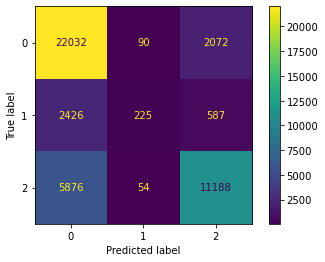

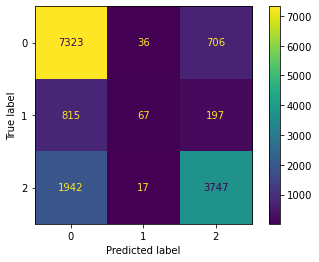

In [114]:
plot_confusion_matrix(gs_model_original_data, X_train, y_train)
plot_confusion_matrix(gs_model_original_data, X_test, y_test);

In [115]:
df.shape

(59400, 26)

### Smote code

In [119]:
imbpipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42, sampling_strategy='not majority')),
    ('smote_trial', LogisticRegression(n_jobs=-1, C=0.01, max_iter=200, tol=0.0001, 
        multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

In [120]:
imbpipe.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ac69e9a0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,...
                                                                                 strategy='constant')),
           

In [121]:
imbpipe.score(X_train, y_train)

0.6690460157126824

Way worse test score....

In [122]:
imbpipe.score(X_test, y_test)

0.663973063973064

In [126]:
accuracy_score(y_train, imbpipe.predict(X_train))

0.6690460157126824

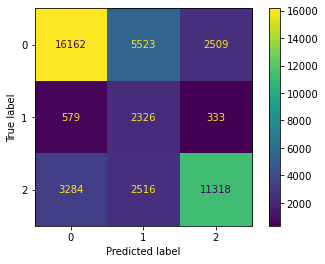

In [125]:
plot_confusion_matrix(imbpipe, X_train, y_train);

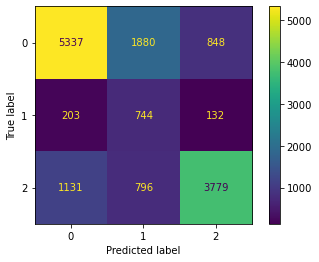

In [124]:
plot_confusion_matrix(imbpipe, X_test, y_test, );

### Grid Search with the smote model! 

In [128]:
for i in imbpipe.get_params().keys():
    print(i)

memory
steps
verbose
ct
sm
smote_trial
ct__n_jobs
ct__remainder
ct__sparse_threshold
ct__transformer_weights
ct__transformers
ct__verbose
ct__subpipe_numerics
ct__subpipe_cat
ct__subpipe_numerics__memory
ct__subpipe_numerics__steps
ct__subpipe_numerics__verbose
ct__subpipe_numerics__mean_impute
ct__subpipe_numerics__ss
ct__subpipe_numerics__mean_impute__add_indicator
ct__subpipe_numerics__mean_impute__copy
ct__subpipe_numerics__mean_impute__fill_value
ct__subpipe_numerics__mean_impute__missing_values
ct__subpipe_numerics__mean_impute__strategy
ct__subpipe_numerics__mean_impute__verbose
ct__subpipe_numerics__ss__copy
ct__subpipe_numerics__ss__with_mean
ct__subpipe_numerics__ss__with_std
ct__subpipe_cat__memory
ct__subpipe_cat__steps
ct__subpipe_cat__verbose
ct__subpipe_cat__cat_impute
ct__subpipe_cat__ohe
ct__subpipe_cat__cat_impute__add_indicator
ct__subpipe_cat__cat_impute__copy
ct__subpipe_cat__cat_impute__fill_value
ct__subpipe_cat__cat_impute__missing_values
ct__subpipe_cat__cat_im

In [104]:
# Just comparing the hyper parameters from the first grid search, dont run this cell

subset_best_params = {'CT__subpipe_numerics__mean_impute__strategy': 'median',
 'subset__C': 0.01,
 'subset__max_iter': 200,
 'subset__solver': 'sag',
 'subset__tol': 0.0001}


The first difference is that the solver of choice for the larger set of data is actually 'newton-cg'. Otherwise, all of the hyperparameters remain the same.

In [107]:
gs_model_original_data = Pipeline(steps=[
    ('CT', CT),
    ('subset', LogisticRegression(n_jobs=-1, C=0.01, max_iter=200, tol=0.0001, multi_class="multinomial", solver='newton-cg', fit_intercept=False))
])

In [108]:
gs_model_original_data.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 2) Processing cat_impute, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing ohe, total=   0.2s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1ac69e9a0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
               

In [135]:
gs_model_original_data.

False

# Write a function to store the results of different model iterations

In [129]:
X.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'construction_year', 'funder', 'installer', 'basin', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'management', 'payment',
       'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object')